<a href="https://colab.research.google.com/github/mat10599/QB_hackaton/blob/main/notebooks/QB_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import scipy.optimize
import scipy
import pandas as pd
from tensorflow import keras
import os
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the data
df = pd.read_csv('drive/MyDrive/data_good/data/train data/metadata.csv')
df["path"] = "drive/MyDrive/data_good/data/train data/" + df["path"] + ".tif"
df.head()

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
0,20230223,id_6675,yes,train,31.528750,74.330625,24,47,drive/MyDrive/data_good/data/train data/images...
1,20230103,id_2542,yes,train,35.538000,112.524000,42,37,drive/MyDrive/data_good/data/train data/images...
2,20230301,id_6546,yes,train,21.060000,84.936667,58,15,drive/MyDrive/data_good/data/train data/images...
3,20230225,id_6084,yes,train,26.756667,80.973333,28,62,drive/MyDrive/data_good/data/train data/images...
4,20230105,id_2012,yes,train,34.800000,40.770000,59,44,drive/MyDrive/data_good/data/train data/images...


In [5]:
# Split the data
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)

## CNN de Base

### preprocess

In [6]:
image = Image.open(train_df.loc[4,'path'])
# image = image.resize((image_height, image_width))
image = np.array(image)
np.max(image)

65535

In [47]:
# Split the data
image_height = 224
image_width = 224
batch_size = 32
num_epochs = 15



train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)
# Load and preprocess images
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image = Image.open(row['path'])
    image = image.resize((image_height, image_width))
    image = np.array(image) #/ 255.0  # Rescale pixel values to [0, 1]
    train_images.append(image)
    train_labels.append(row['plume'])

train_images = np.array(train_images) / np.max(train_images)
train_labels = np.array(train_labels)

validation_images = []
validation_labels = []

for index, row in val_df.iterrows():
    image = Image.open(row['path'])
    image = image.resize((image_height, image_width))
    image = np.array(image) #/ 255.0  # Rescale pixel values to [0, 1]
    validation_images.append(image)
    validation_labels.append(row['plume'])

validation_images = np.array(validation_images) / np.max(validation_images)
validation_labels = np.array(validation_labels)

test_images = []  # Load and preprocess test images similarly
test_labels = []

for index, row in test_df.iterrows():
    image = Image.open(row['path'])
    image = image.resize((image_height, image_width))
    image = np.array(image) #/ 255.0  # Rescale pixel values to [0, 1]
    test_images.append(image)
    test_labels.append(row['plume'])

test_images = np.array(test_images) / np.max(test_images)
test_labels = np.array(test_labels)

# Convert string labels to numerical format in your data frames
train_df['plume'] = train_df['plume'].map({'yes': 1, 'no': 0})
val_df['plume'] = val_df['plume'].map({'yes': 1, 'no': 0})
test_df['plume'] = test_df['plume'].map({'yes': 1, 'no': 0})

# Now convert the labels to NumPy arrays
train_labels = np.array(train_df['plume'])
validation_labels = np.array(val_df['plume'])
test_labels = np.array(test_df['plume'])

# Create an instance of the ImageDataGenerator
traindatagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    # preprocessing_function=upscale_image,
)

valdatagen = ImageDataGenerator(
)

train_images = train_images.reshape(train_images.shape + (1,))
train_datagen = traindatagen.flow(
    train_images, train_labels, batch_size=batch_size)

validation_images = validation_images.reshape(validation_images.shape + (1,))
validation_datagen = valdatagen.flow(
    validation_images, validation_labels, batch_size=batch_size)

test_images = test_images.reshape(test_images.shape + (1,))
test_datagen = valdatagen.flow(
    test_images, test_labels, batch_size=batch_size)

In [48]:
np.max(train_images)

1.0

### model

In [50]:
# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3),
                 activation='relu',
                 input_shape=(image_height, image_width, 1)
                 ))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten the feature maps
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0008),
    # optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC'])

# Train the model
epochs = 15  # Adjust the number of training epochs as needed
model.fit(train_datagen, validation_data=validation_datagen, epochs=epochs)



Epoch 1/15
10/10 [==============================] - 39s 4s/step - loss: 0.7474 - auc: 0.5720 - val_loss: 0.6897 - val_auc: 0.9062
Epoch 2/15
10/10 [==============================] - 35s 3s/step - loss: 0.6584 - auc: 0.7235 - val_loss: 0.6436 - val_auc: 0.9190
Epoch 3/15
10/10 [==============================] - 32s 3s/step - loss: 0.6274 - auc: 0.8022 - val_loss: 0.6438 - val_auc: 0.9174
Epoch 4/15
10/10 [==============================] - 33s 3s/step - loss: 0.5907 - auc: 0.8230 - val_loss: 0.5329 - val_auc: 0.9185
Epoch 5/15
10/10 [==============================] - 31s 3s/step - loss: 0.5758 - auc: 0.7869 - val_loss: 0.5103 - val_auc: 0.9215
Epoch 6/15
10/10 [==============================] - 32s 3s/step - loss: 0.5285 - auc: 0.8282 - val_loss: 0.5905 - val_auc: 0.9333
Epoch 7/15
10/10 [==============================] - 34s 3s/step - loss: 0.5166 - auc: 0.8369 - val_loss: 0.5373 - val_auc: 0.9359
Epoch 8/15
10/10 [==============================] - 31s 3s/step - loss: 0.5377 - auc: 0.81

In [55]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_datagen)
print("Test AUC:", test_accuracy)

3/3 [==============================] - 2s 551ms/step - loss: 0.5664 - auc: 0.8302
Test AUC: 0.830170750617981


In [56]:
final_df = pd.read_csv('drive/MyDrive/data_good/data/test data/metadata.csv')

In [57]:
final_images = []  # Load and preprocess test images similarly
submission_df = pd.read_csv('drive/MyDrive/data_good/data/submission_test_file.csv')
image_folder = 'drive/MyDrive/data_good/data/test data'
for index, row in submission_df.iterrows():
    image = Image.open('drive/MyDrive/data_good/data/test data/images/'+row["path"])
    image = image.resize((image_height, image_width))
    image = np.array(image)
    final_images.append(image)

final_images = np.array(final_images) / np.max(final_images)
print(final_images.shape)

(108, 224, 224)


In [58]:
predictions = model.predict(final_images)
df_predictions= pd.DataFrame(predictions, columns=["plume?"])

4/4 [==============================] - 3s 595ms/step


In [59]:
submission_df['label'] = df_predictions['plume?']
# submission_df
submission_df.to_csv('submission8.csv', index=False)

In [180]:
model.save('CNN5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## EfficientNet

In [157]:
# Split the data
image_height = 224
image_width = 224
batch_size = 32
num_epochs = 10


train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)
# Load and preprocess images
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0
    train_images.append(image)
    train_labels.append(row['plume'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

validation_images = []
validation_labels = []

for index, row in val_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0
    validation_images.append(image)
    validation_labels.append(row['plume'])

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

test_images = []
test_labels = []

for index, row in test_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0
    test_images.append(image)
    test_labels.append(row['plume'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Convert string labels to numerical format in your data frames
train_df['plume'] = train_df['plume'].map({'yes': 1, 'no': 0})
val_df['plume'] = val_df['plume'].map({'yes': 1, 'no': 0})
test_df['plume'] = test_df['plume'].map({'yes': 1, 'no': 0})

# Now convert the labels to NumPy arrays
train_labels = np.array(train_df['plume'])
validation_labels = np.array(val_df['plume'])
test_labels = np.array(test_df['plume'])

# Create an instance of the ImageDataGenerator
traindatagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

valdatagen = ImageDataGenerator(
)

train_datagen = traindatagen.flow(
    train_images, train_labels, batch_size=batch_size)

validation_datagen = valdatagen.flow(
    validation_images, validation_labels, batch_size=batch_size)

test_datagen = valdatagen.flow(
    test_images, test_labels, batch_size=batch_size)

In [161]:
def build_model():
    inputs = layers.Input(shape=(224, 224, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    # x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"]
    )
    return model

model = build_model()

epochs = 10
hist = model.fit(train_datagen, epochs=epochs, validation_data=validation_datagen, verbose=2)

Epoch 1/10
10/10 - 42s - loss: 0.7014 - auc: 0.4633 - val_loss: 0.6830 - val_auc: 0.5000 - 42s/epoch - 4s/step
Epoch 2/10
10/10 - 31s - loss: 0.7099 - auc: 0.4368 - val_loss: 0.7193 - val_auc: 0.5513 - 31s/epoch - 3s/step
Epoch 3/10
10/10 - 32s - loss: 0.6939 - auc: 0.5028 - val_loss: 0.6909 - val_auc: 0.5344 - 32s/epoch - 3s/step
Epoch 4/10
10/10 - 34s - loss: 0.6948 - auc: 0.5025 - val_loss: 0.7012 - val_auc: 0.5262 - 34s/epoch - 3s/step
Epoch 5/10
10/10 - 32s - loss: 0.6974 - auc: 0.4824 - val_loss: 0.7085 - val_auc: 0.4831 - 32s/epoch - 3s/step
Epoch 6/10
10/10 - 30s - loss: 0.6921 - auc: 0.5190 - val_loss: 0.6982 - val_auc: 0.4903 - 30s/epoch - 3s/step
Epoch 7/10
10/10 - 32s - loss: 0.6993 - auc: 0.4739 - val_loss: 0.7237 - val_auc: 0.5200 - 32s/epoch - 3s/step
Epoch 8/10


KeyboardInterrupt: ignored

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
model.save('EfficientNet1.h5')

## VGG

In [181]:
# Split the data
image_height = 224
image_width = 224
batch_size = 32
num_epochs = 10


train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)
# Load and preprocess images
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    train_images.append(image)
    train_labels.append(row['plume'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

validation_images = []
validation_labels = []

for index, row in val_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    validation_images.append(image)
    validation_labels.append(row['plume'])

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

test_images = []  # Load and preprocess test images similarly
test_labels = []

for index, row in test_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    test_images.append(image)
    test_labels.append(row['plume'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Convert string labels to numerical format in your data frames
train_df['plume'] = train_df['plume'].map({'yes': 1, 'no': 0})
val_df['plume'] = val_df['plume'].map({'yes': 1, 'no': 0})
test_df['plume'] = test_df['plume'].map({'yes': 1, 'no': 0})

# Now convert the labels to NumPy arrays
train_labels = np.array(train_df['plume'])
validation_labels = np.array(val_df['plume'])
test_labels = np.array(test_df['plume'])

# Create an instance of the ImageDataGenerator
traindatagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    # preprocessing_function=upscale_image,
)

valdatagen = ImageDataGenerator(
)

# train_images = train_images.reshape(train_images.shape + (1,))
train_datagen = traindatagen.flow(train_images, train_labels, batch_size=batch_size)
# validation_images = validation_images.reshape(validation_images.shape + (1,))
validation_datagen = valdatagen.flow(validation_images, validation_labels, batch_size=batch_size)
# test_images = test_images.reshape(test_images.shape + (1,))
test_datagen = valdatagen.flow(test_images, test_labels, batch_size=batch_size)

In [182]:
# Load the pre-trained EfficientNetB0 model
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
# model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Freeze the pre-trained layers for fine-tuning
for layer in pretrained_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.0008), loss='binary_crossentropy', metrics=['AUC'])

history = model.fit(train_datagen,
                    validation_data=validation_datagen,
                    epochs=num_epochs)

test_loss, test_accuracy = model.evaluate(test_images, test_labels)

Epoch 1/10
10/10 [==============================] - 239s 24s/step - loss: 1.2552 - auc: 0.4854 - val_loss: 0.8209 - val_auc: 0.7738
Epoch 2/10
 9/10 [==========================>...] - ETA: 19s - loss: 0.7012 - auc: 0.6028

KeyboardInterrupt: ignored

In [177]:
model.save("VGG2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## MobileNet


### preprocess

In [162]:
# Split the data
image_height = 224
image_width = 224
batch_size = 32
num_epochs = 10


train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)
# Load and preprocess images
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    train_images.append(image)
    train_labels.append(row['plume'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

validation_images = []
validation_labels = []

for index, row in val_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    validation_images.append(image)
    validation_labels.append(row['plume'])

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

test_images = []  # Load and preprocess test images similarly
test_labels = []

for index, row in test_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    test_images.append(image)
    test_labels.append(row['plume'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Convert string labels to numerical format in your data frames
train_df['plume'] = train_df['plume'].map({'yes': 1, 'no': 0})
val_df['plume'] = val_df['plume'].map({'yes': 1, 'no': 0})
test_df['plume'] = test_df['plume'].map({'yes': 1, 'no': 0})

# Now convert the labels to NumPy arrays
train_labels = np.array(train_df['plume'])
validation_labels = np.array(val_df['plume'])
test_labels = np.array(test_df['plume'])

# Create an instance of the ImageDataGenerator
traindatagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    # preprocessing_function=upscale_image,
)

valdatagen = ImageDataGenerator(
)

# train_images = train_images.reshape(train_images.shape + (1,))
train_datagen = traindatagen.flow(train_images, train_labels, batch_size=batch_size)
# validation_images = validation_images.reshape(validation_images.shape + (1,))
validation_datagen = valdatagen.flow(validation_images, validation_labels, batch_size=batch_size)
# test_images = test_images.reshape(test_images.shape + (1,))
test_datagen = valdatagen.flow(test_images, test_labels, batch_size=batch_size)

### model

In [165]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import binary_crossentropy

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)


model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))



for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=['AUC'])

# for layer in base_model.layers:
#     layer.trainable = True

# # It's good to use a smaller learning rate for fine-tuning

# model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

model.fit(train_datagen, epochs=20, validation_data=validation_datagen, callbacks=[early_stopper])

Epoch 1/20
10/10 [==============================] - 26s 2s/step - loss: 0.9443 - auc: 0.4761 - val_loss: 0.6443 - val_auc: 0.6938
Epoch 2/20
10/10 [==============================] - 25s 2s/step - loss: 0.6364 - auc: 0.6758 - val_loss: 0.6688 - val_auc: 0.7728
Epoch 3/20
10/10 [==============================] - 17s 2s/step - loss: 0.6634 - auc: 0.6609 - val_loss: 0.5748 - val_auc: 0.7482
Epoch 4/20
10/10 [==============================] - 30s 3s/step - loss: 0.5835 - auc: 0.7592 - val_loss: 0.6173 - val_auc: 0.7826
Epoch 5/20
10/10 [==============================] - 26s 3s/step - loss: 0.5695 - auc: 0.7752 - val_loss: 0.7672 - val_auc: 0.7764
Epoch 6/20
10/10 [==============================] - 19s 2s/step - loss: 0.6174 - auc: 0.7239 - val_loss: 0.6392 - val_auc: 0.7651
Epoch 7/20
10/10 [==============================] - 20s 2s/step - loss: 0.6079 - auc: 0.7342 - val_loss: 0.5683 - val_auc: 0.7462
Epoch 8/20
10/10 [==============================] - 18s 2s/step - loss: 0.6062 - auc: 0.74

In [166]:
# model.save('MobileNet1.h5')
test_loss, test_accuracy = model.evaluate(test_datagen)
print(f"Test accuracy: {test_accuracy:.2f}")

3/3 [==============================] - 2s 529ms/step - loss: 0.5328 - auc: 0.8046
Test accuracy: 0.80


In [140]:
sample_batch, sample_labels = next(validation_datagen)
sample_batch, sample_labels = next(train_datagen)

data_type = sample_batch.dtype

# Print the data type
print("Data type of the batch:", data_type)

Data type of the batch: float32


## RESNET




In [141]:
train_labels.dtype

dtype('int64')

In [167]:
# Split the data
image_height = 224
image_width = 224
batch_size = 32
num_epochs = 10


train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)
# Load and preprocess images
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    train_images.append(image)
    train_labels.append(row['plume'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

validation_images = []
validation_labels = []

for index, row in val_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    validation_images.append(image)
    validation_labels.append(row['plume'])

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

test_images = []  # Load and preprocess test images similarly
test_labels = []

for index, row in test_df.iterrows():
    image = Image.open(row['path'])
    image = image.convert('RGB')
    image = image.resize((image_height, image_width))
    image = np.array(image) / 255.0  # Rescale pixel values to [0, 1]
    test_images.append(image)
    test_labels.append(row['plume'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Convert string labels to numerical format in your data frames
train_df['plume'] = train_df['plume'].map({'yes': 1, 'no': 0})
val_df['plume'] = val_df['plume'].map({'yes': 1, 'no': 0})
test_df['plume'] = test_df['plume'].map({'yes': 1, 'no': 0})

# Now convert the labels to NumPy arrays
train_labels = np.array(train_df['plume'])
validation_labels = np.array(val_df['plume'])
test_labels = np.array(test_df['plume'])

# Create an instance of the ImageDataGenerator
traindatagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    # preprocessing_function=upscale_image,
)

valdatagen = ImageDataGenerator(
)

# train_images = train_images.reshape(train_images.shape + (1,))
train_datagen = traindatagen.flow(train_images, train_labels, batch_size=batch_size)
# validation_images = validation_images.reshape(validation_images.shape + (1,))
validation_datagen = valdatagen.flow(validation_images, validation_labels, batch_size=batch_size)
# test_images = test_images.reshape(test_images.shape + (1,))
test_datagen = valdatagen.flow(test_images, test_labels, batch_size=batch_size)

In [171]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output

# Apply GlobalAveragePooling2D layer once
x = GlobalAveragePooling2D()(x)

# Add your fully connected layers
# x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# Create the output layer for binary classification (1 neuron, sigmoid activation)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=['AUC'])


early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

model.fit(train_datagen, epochs=20, validation_data=validation_datagen, callbacks=[early_stopper])



Epoch 1/20


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7d89d9facb80>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


10/10 [==============================] - 192s 9s/step - loss: 1.0047 - auc: 0.5456 - val_loss: 0.7121 - val_auc: 0.7000
Epoch 2/20
10/10 [==============================] - 88s 9s/step - loss: 0.7351 - auc: 0.5509 - val_loss: 0.8295 - val_auc: 0.6954
Epoch 3/20
10/10 [==============================] - 87s 9s/step - loss: 0.6948 - auc: 0.5497 - val_loss: 0.7262 - val_auc: 0.6744
Epoch 4/20
10/10 [==============================] - 88s 9s/step - loss: 0.6952 - auc: 0.5882 - val_loss: 0.6419 - val_auc: 0.6667
Epoch 5/20
10/10 [==============================] - 87s 9s/step - loss: 0.6894 - auc: 0.5575 - val_loss: 0.7069 - val_auc: 0.6713
Epoch 6/20
10/10 [==============================] - 85s 9s/step - loss: 0.6717 - auc: 0.6140 - val_loss: 0.6606 - val_auc: 0.6703
Epoch 7/20
10/10 [==============================] - 86s 9s/step - loss: 0.6332 - auc: 0.7090 - val_loss: 0.6610 - val_auc: 0.6764
Epoch 8/20
10/10 [==============================] - 87s 9s/step - loss: 0.6504 - auc: 0.6717 - val_l

In [174]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
model.save('resnet1.h5')

3/3 [==============================] - 42s 11s/step - loss: 0.7250 - auc: 0.8017


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Machine learning

In [233]:
!pip install xgboost
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [263]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image = Image.open(row['path'])
    image = np.array(image) #/ 255.0  # Rescale pixel values to [0, 1]
    train_images.append(image)
    train_labels.append(row['plume'])

train_images = np.array(train_images)
data_train = train_images.reshape(train_images.shape[0], -1)

train_labels = np.array(train_labels)
label_mapping = {'yes': 1, 'no': 0}
train_labels = np.vectorize(label_mapping.get)(train_labels)
train_labels = train_labels.reshape(-1, 1)

test_images = []  # Load and prdeprocess test images similarly
test_labels = []

for index, row in test_df.iterrows():
    image = Image.open(row['path'])
    image = np.array(image) #/ 255.0  # Rescale pixel values to [0, 1]
    test_images.append(image)
    test_labels.append(row['plume'])

test_images = np.array(test_images)
data_test = test_images.reshape(test_images.shape[0], -1)

test_labels = np.array(test_labels)
label_mapping = {'yes': 1, 'no': 0}
test_labels = np.vectorize(label_mapping.get)(test_labels)
test_labels = test_labels.reshape(-1, 1)

# histograms_train = []

# # Calculate histograms for each image
# for image in data_train:
#     hist, _ = np.histogram(image, bins=256, range=(0, 256))
#     histograms_train.append(hist)

# # Convert the list of histograms to a NumPy array
# histograms_train = np.array(histograms_train)

# histograms_test = []

# # Calculate histograms for each image
# for image in data_test:
#     hist, _ = np.histogram(image, bins=256, range=(0, 256))
#     histograms_test.append(hist)

# # Convert the list of histograms to a NumPy array
# histograms_test = np.array(histograms_test)

In [286]:
np.max(train_images)

array([76, 14, 17])

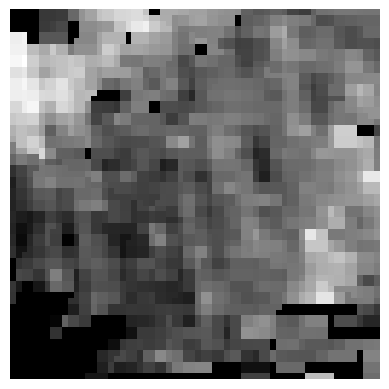

In [288]:
which_one = -13
print(test_labels[which_one])
studied = test_images[which_one]
print

# Define the threshold
threshold = 65000

# Count the number of values above the threshold
count = np.sum(studied > threshold)
print(count)

plt.imshow(test_images[which_one], cmap='gray', vmin=0, vmax=65535)
plt.axis('off')  # Turn off axis labels
plt.show()


[0]
0


In [237]:
import xgboost as xgb
import catboost

model = xgb.XGBClassifier()
# model = catboost.CatBoostClassifier(verbose=False)

# Train the model on the training data
model.fit(histograms_train, train_labels)

# Make predictions on the testing data
y_pred = model.predict(histograms_test)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(test_labels, y_pred)
report = classification_report(test_labels, y_pred)
confusion = confusion_matrix(test_labels, y_pred)

print("Accuracy:", accuracy)



Accuracy: 0.7441860465116279


In [325]:
threshold = 65500

def model_predict(data):
  predictions = []
  for i in data:
    if np.max(i) > threshold:
      count+=1
      predictions.append(1)
    else:
      predictions.append(0)
  return np.array(predictions), i

y_pred, i = model_predict(data_test)

In [324]:
accuracy = accuracy_score(test_labels, y_pred)
report = classification_report(test_labels, y_pred)
confusion = confusion_matrix(test_labels, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.5930232558139535


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [284]:
import numpy as np

# Sample 2D NumPy array
data = np.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9],
                 [76, 14, 17]])

threshold = 6  # Define the threshold
print(data.shape)

# Initialize an empty list to store the results
results = []

# Iterate over the first dimension (rows) of the array
for row in data:
    # Check if the maximum value in the row is greater than the threshold
    if np.max(row) > threshold:
        results.append(True)
    else:
        results.append(False)

# Convert the results list to a NumPy array
results = np.array(results)

print("Results:", results)


(4, 3)
Results: [False False  True  True]
